<a href="https://colab.research.google.com/github/briangasca/Models/blob/main/KERAS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
scaler = MinMaxScaler(feature_range=(0,1))

In [41]:
#Data download
df = yf.download(tickers=['TSLA'], period='5y')
y = df['Close'].fillna(method='ffill')
#reshape to 2D array
y= y.values.reshape(-1,1)

#Scaling data
scaler = scaler.fit(y)
y = scaler.transform(y)

#input output sequences
n_lookback = 60
n_forecast = 360

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
  X.append(y[i-n_lookback: i])
  Y.append(y[i:i + n_forecast])

X = np.array(X)
Y = np.array(Y)

[*********************100%%**********************]  1 of 1 completed


In [42]:
#Fitting Model

model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(n_lookback,1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X,Y,epochs=100,batch_size=32)

#generate forecasts (predictions)
X_predict = y[-n_lookback:]
X_predict = X_predict.reshape(1,n_lookback,1)

Y_predict = model.predict(X_predict).reshape(-1,1)
Y_predict = scaler.inverse_transform(Y_predict)

Epoch 1/100
27/27 [==============================] - 8s 17ms/step - loss: 0.1510
Epoch 2/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0415
Epoch 3/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0335
Epoch 4/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0286
Epoch 5/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0258
Epoch 6/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0238
Epoch 7/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0228
Epoch 8/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0225
Epoch 9/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0214
Epoch 10/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0205
Epoch 11/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0201
Epoch 12/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0197
Epoch 13/100
27/27 [=====

1/1 [==============================] - 1s 1s/step


<ipython-input-81-0c237efcd791>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


            Actual    Forecast
Date                          
2024-08-26     NaN  277.861115
2024-08-27     NaN  279.688568
2024-08-28     NaN  279.661377
2024-08-29     NaN  280.035889
2024-08-30     NaN  281.305176


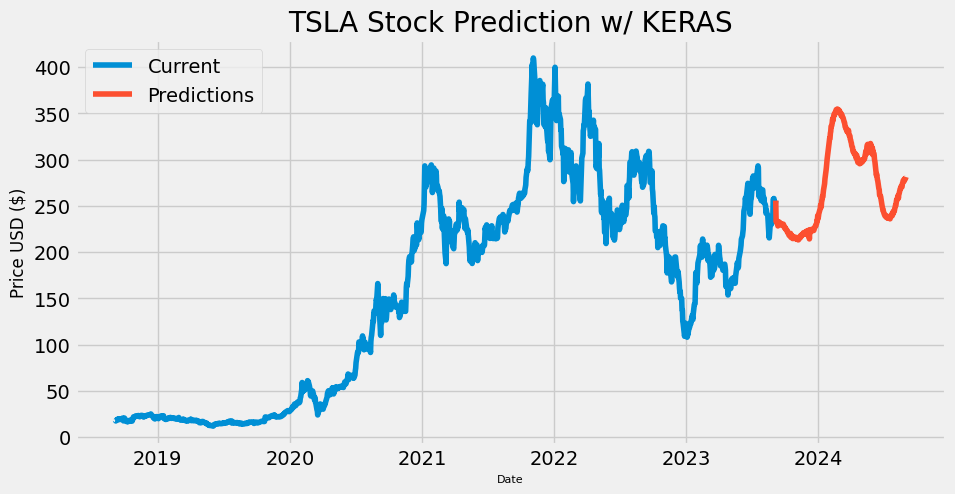

In [81]:
#Organizing results in a data frame

df_past = df[['Close']].reset_index()

#Making new columns, If "forecast" shows up then set it to NaN and append all 'Actual' values.
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

# Making forecast column, after all the 'Actual' values are added, start appending 'Forecast' values and set 'Actual' to NaN
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_predict.flatten()
df_future['Actual'] = np.nan

#Concat actual + forecast
results = df_past.append(df_future).set_index('Date')
print(results.tail())

#Plotting
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.title('TSLA Stock Prediction w/ KERAS')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Price USD ($)', fontsize=12)

plt.plot(results[['Actual','Forecast']])

plt.legend(['Current','Predictions'], loc='upper left')
plt.show()

